In [1]:
import sys

sys.path.append("../input/sentence-transformers")


In [2]:
import sentence_transformers

print("Sentence Transformers:", sentence_transformers.__version__)


Sentence Transformers: 2.2.2


In [3]:
import nltk
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()
nltk.download("all", quiet=True)


True

In [4]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [5]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.set_caching_enabled(False)

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [6]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenizing(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)


train_tokenized, word2idx, max_len = tokenizing(vispam_datasets['train']['clean_comment'])
print('Number of words:', len(word2idx))
print('Max length of sentence:', max_len)


Number of words: 15359
Max length of sentence: 215


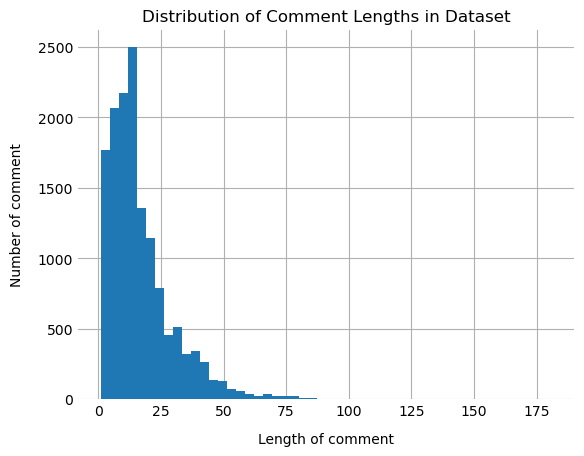

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([len(s.split()) for s in vispam_datasets['train']['clean_comment']], bins=50)
ax.set_title('Distribution of Comment Lengths in Dataset', fontsize=12)
ax.set_xlabel("Length of comment", fontsize=10, labelpad=10)
ax.set_ylabel('Number of comment', fontsize=10, labelpad=10)
for pos in ['right', 'top', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.grid()
ax.set_axisbelow(True)
plt.show()


In [8]:
import torch
import numpy as np
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


file_name = "/kaggle/input/fasttext-pretrained-embeddings/cc.vi.300.vec"
embeddings = load_pretrained_vectors(word2idx, file_name)
embeddings = torch.tensor(embeddings)


0it [00:00, ?it/s]

There are 8584 / 15359 pretrained vectors found.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    
    def __init__(self, task, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static'):
        super(TextCNN, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        self.desc_size = 768
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
            
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters + self.desc_size, self.num_classes)

    def forward(self, input_ids, description):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        x = torch.cat((x, description), dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')

            
class BiLSTM(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiLSTM, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        self.desc_size = 768
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64 + self.desc_size, self.num_classes)
        
    def forward(self, input_ids, description):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), dim=1)
        conc = self.relu(self.linear(conc))
        conc = torch.cat((conc, description), dim=1)
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiGRU(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiGRU, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        self.desc_size = 768
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.load_embeddings()
        self.gru = nn.GRU(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64 + self.desc_size, self.num_classes)
        
    def forward(self, input_ids, description):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
            
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = torch.cat((conc, description), dim=1)
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

In [10]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [11]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in train_dataloader:
        input_ids = data['input_ids'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, description)
        
        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())
        
    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            description = data[f'encoded_description_{task}'].to(device)
            labels = data[label_column].to(device)

            outputs = model(input_ids, description)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, model_name, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model_name, f"{model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model_name, f"{model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model_name, f"{model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*70)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            break
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model_name, f"{model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history
    

def test(model, dataloader, task):
    model.eval()
    
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, description)
         
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    colors = plt.get_cmap('tab10').colors
    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [12]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# TextCNN - SBERT with PhoBERT

In [14]:
from sentence_transformers import SentenceTransformer

model_dir = '../input/vispam-description-embedding-phobert/'
sentence_model_1 = SentenceTransformer(model_dir + 'training_nli_vinai-phobert-base-task-1-tokenized', device=device)
sentence_model_2 = SentenceTransformer(model_dir + 'training_nli_vinai-phobert-base-task-2-tokenized', device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_tokenized_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_tokenized_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

vispam_datasets = vispam_datasets.map(encode_description, batched=True)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [15]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    
    return {'input_ids': input_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)


## Task 1

In [17]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=1, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN_Description_PhoBERT", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.6207 - Train F1-score: 0.5768 - Train Loss: 0.6581
Valid Accuracy: 0.6388 - Valid F1-score: 0.5686 - Valid Loss: 0.6661
Validation loss decreased (inf --> 0.666150). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.6727 - Train F1-score: 0.6241 - Train Loss: 0.6289
Valid Accuracy: 0.6658 - Valid F1-score: 0.5997 - Valid Loss: 0.6391
Validation loss decreased (0.666150 --> 0.639113). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.7127 - Train F1-score: 0.6634 - Train Loss: 0.5962
Valid Accuracy: 0.6847 - Valid F1-score: 0.6319 - Valid Loss: 0.6028
Validation loss decreased (0.639113 --> 0.602759). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [18]:
save_visualization_history(history, 'TextCNN_Description_PhoBERT', task=1)
plotting_history(history)


In [19]:
import os
import torch

model_name = "TextCNN_Description_PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = TextCNN(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8302
Precision: 0.7817
Recall: 0.7882
F1-score: 0.7848
Confusion matrix:
 [[2555  356]
 [ 317  735]]
              precision    recall  f1-score   support

           0     0.8896    0.8777    0.8836      2911
           1     0.6737    0.6987    0.6860      1052

    accuracy                         0.8302      3963
   macro avg     0.7817    0.7882    0.7848      3963
weighted avg     0.8323    0.8302    0.8312      3963



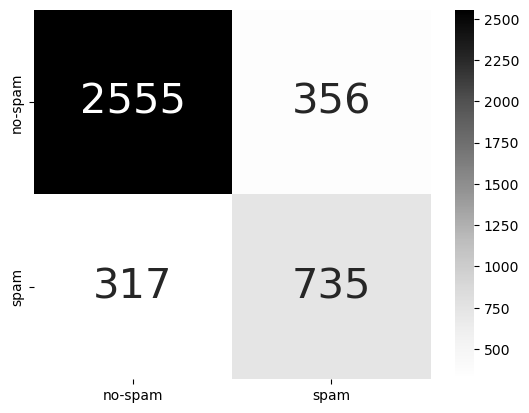

In [20]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [21]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=2, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN_Description_PhoBERT", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.5082 - Train F1-score: 0.3583 - Train Loss: 1.1081
Valid Accuracy: 0.5305 - Valid F1-score: 0.3721 - Valid Loss: 1.1653
Validation loss decreased (inf --> 1.165286). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.6451 - Train F1-score: 0.4984 - Train Loss: 0.7735
Valid Accuracy: 0.6853 - Valid F1-score: 0.4893 - Valid Loss: 1.0718
Validation loss decreased (1.165286 --> 1.071823). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.7327 - Train F1-score: 0.5913 - Train Loss: 0.6073
Valid Accuracy: 0.7042 - Valid F1-score: 0.5114 - Valid Loss: 1.0474
Validation loss decreased (1.071823 --> 1.047387). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [22]:
save_visualization_history(history, 'TextCNN_Description_PhoBERT', task=2)
plotting_history(history)


In [23]:
import os
import torch

model_name = "TextCNN_Description_PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = TextCNN(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7984
Precision: 0.5821
Recall: 0.6624
F1-score: 0.6084
Confusion matrix:
 [[2504   47  209  151]
 [  17   30    4    3]
 [ 109    4  179   17]
 [ 181   21   36  451]]
              precision    recall  f1-score   support

           0     0.8908    0.8602    0.8752      2911
           1     0.2941    0.5556    0.3846        54
           2     0.4182    0.5793    0.4858       309
           3     0.7251    0.6546    0.6880       689

    accuracy                         0.7984      3963
   macro avg     0.5821    0.6624    0.6084      3963
weighted avg     0.8170    0.7984    0.8056      3963



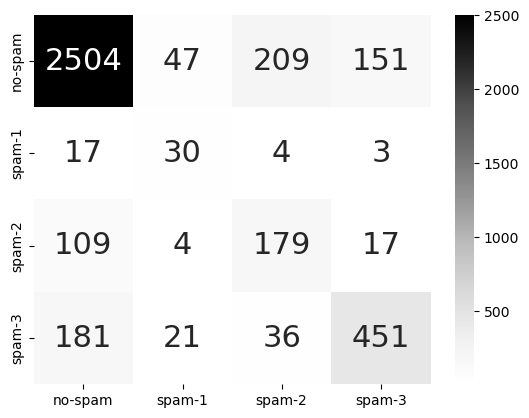

In [24]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - SBERT with PhoBERT

## Task 1

In [25]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM_Description_PhoBERT", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.6750 - Train F1-score: 0.6300 - Train Loss: 0.6156
Valid Accuracy: 0.7772 - Valid F1-score: 0.7157 - Valid Loss: 0.5367
Validation loss decreased (inf --> 0.536702). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.8008 - Train F1-score: 0.7651 - Train Loss: 0.4425
Valid Accuracy: 0.7760 - Valid F1-score: 0.7391 - Valid Loss: 0.4615
Validation loss decreased (0.536702 --> 0.461459). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.8402 - Train F1-score: 0.8088 - Train Loss: 0.3734
Valid Accuracy: 0.8351 - Valid F1-score: 0.7847 - Valid Loss: 0.4533
Validation loss decreased (0.461459 --> 0.453313). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [26]:
save_visualization_history(history, 'BiLSTM_Description_PhoBERT', task=1)
plotting_history(history)


In [27]:
import os
import torch

model_name = "BiLSTM_Description_PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiLSTM(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8413
Precision: 0.7983
Recall: 0.7888
F1-score: 0.7933
Confusion matrix:
 [[2622  289]
 [ 340  712]]
              precision    recall  f1-score   support

           0     0.8852    0.9007    0.8929      2911
           1     0.7113    0.6768    0.6936      1052

    accuracy                         0.8413      3963
   macro avg     0.7983    0.7888    0.7933      3963
weighted avg     0.8390    0.8413    0.8400      3963



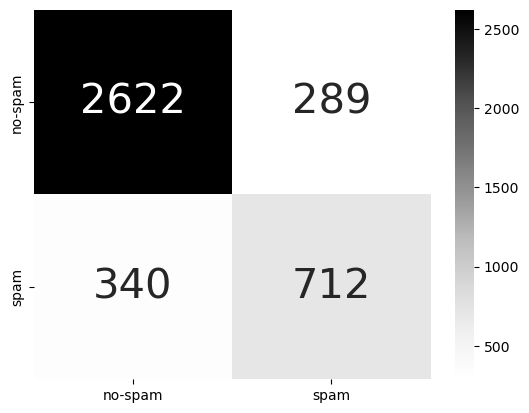

In [28]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [29]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM_Description_PhoBERT", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.4564 - Train F1-score: 0.3137 - Train Loss: 1.2186
Valid Accuracy: 0.4953 - Valid F1-score: 0.3151 - Valid Loss: 1.3095
Validation loss decreased (inf --> 1.309477). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.5494 - Train F1-score: 0.4163 - Train Loss: 0.9423
Valid Accuracy: 0.6174 - Valid F1-score: 0.4333 - Valid Loss: 1.2226
Validation loss decreased (1.309477 --> 1.222581). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.6221 - Train F1-score: 0.4951 - Train Loss: 0.7538
Valid Accuracy: 0.6237 - Valid F1-score: 0.4529 - Valid Loss: 1.0877
Validation loss decreased (1.222581 --> 1.087718). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [30]:
save_visualization_history(history, 'BiLSTM_Description_PhoBERT', task=2)
plotting_history(history)


In [31]:
import os
import torch

model_name = "BiLSTM_Description_PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiLSTM(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7716
Precision: 0.5725
Recall: 0.7030
F1-score: 0.6113
Confusion matrix:
 [[2283   49  388  191]
 [  13   30    7    4]
 [  72    0  219   18]
 [ 103   14   46  526]]
              precision    recall  f1-score   support

           0     0.9239    0.7843    0.8484      2911
           1     0.3226    0.5556    0.4082        54
           2     0.3318    0.7087    0.4520       309
           3     0.7118    0.7634    0.7367       689

    accuracy                         0.7716      3963
   macro avg     0.5725    0.7030    0.6113      3963
weighted avg     0.8327    0.7716    0.7921      3963



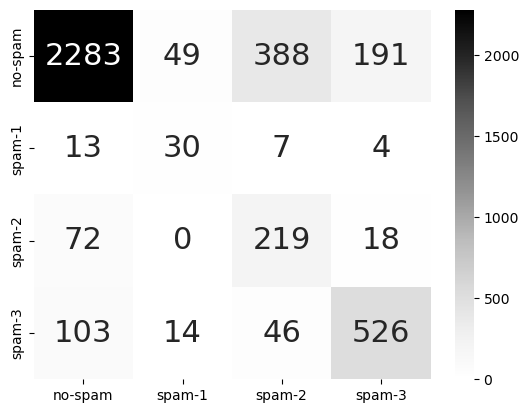

In [32]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - SBERT with PhoBERT

## Task 1

In [33]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU_Description_PhoBERT", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.6926 - Train F1-score: 0.6502 - Train Loss: 0.5932
Valid Accuracy: 0.7854 - Valid F1-score: 0.7403 - Valid Loss: 0.4820
Validation loss decreased (inf --> 0.482006). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.8116 - Train F1-score: 0.7772 - Train Loss: 0.4288
Valid Accuracy: 0.8357 - Valid F1-score: 0.7792 - Valid Loss: 0.4641
Validation loss decreased (0.482006 --> 0.464144). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.8460 - Train F1-score: 0.8149 - Train Loss: 0.3609
Valid Accuracy: 0.8175 - Valid F1-score: 0.7764 - Valid Loss: 0.4533
Validation loss decreased (0.464144 --> 0.453331). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [34]:
save_visualization_history(history, 'BiGRU_Description_PhoBERT', task=1)
plotting_history(history)


In [35]:
import os
import torch

model_name = "BiGRU_Description_PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiGRU(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8405
Precision: 0.7956
Recall: 0.7949
F1-score: 0.7953
Confusion matrix:
 [[2597  314]
 [ 318  734]]
              precision    recall  f1-score   support

           0     0.8909    0.8921    0.8915      2911
           1     0.7004    0.6977    0.6990      1052

    accuracy                         0.8405      3963
   macro avg     0.7956    0.7949    0.7953      3963
weighted avg     0.8403    0.8405    0.8404      3963



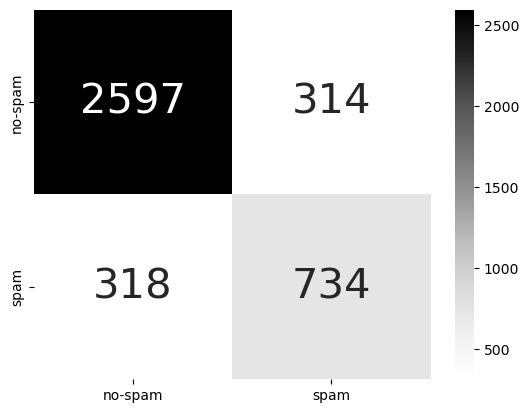

In [36]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [37]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU_Description_PhoBERT", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.4638 - Train F1-score: 0.3184 - Train Loss: 1.2081
Valid Accuracy: 0.4940 - Valid F1-score: 0.3401 - Valid Loss: 1.2680
Validation loss decreased (inf --> 1.268039). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.5547 - Train F1-score: 0.4167 - Train Loss: 0.9436
Valid Accuracy: 0.6488 - Valid F1-score: 0.4498 - Valid Loss: 1.2203
Validation loss decreased (1.268039 --> 1.220269). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.6701 - Train F1-score: 0.5204 - Train Loss: 0.7056
Valid Accuracy: 0.6463 - Valid F1-score: 0.4680 - Valid Loss: 1.0771
Validation loss decreased (1.220269 --> 1.077063). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [38]:
save_visualization_history(history, 'BiGRU_Description_PhoBERT', task=2)
plotting_history(history)


In [39]:
import os
import torch

model_name = "BiGRU_Description_PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiGRU(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7961
Precision: 0.5821
Recall: 0.7004
F1-score: 0.6239
Confusion matrix:
 [[2384   52  276  199]
 [  13   30    5    6]
 [  85    4  197   23]
 [ 103    9   33  544]]
              precision    recall  f1-score   support

           0     0.9222    0.8190    0.8675      2911
           1     0.3158    0.5556    0.4027        54
           2     0.3855    0.6375    0.4805       309
           3     0.7047    0.7896    0.7447       689

    accuracy                         0.7961      3963
   macro avg     0.5821    0.7004    0.6239      3963
weighted avg     0.8343    0.7961    0.8097      3963



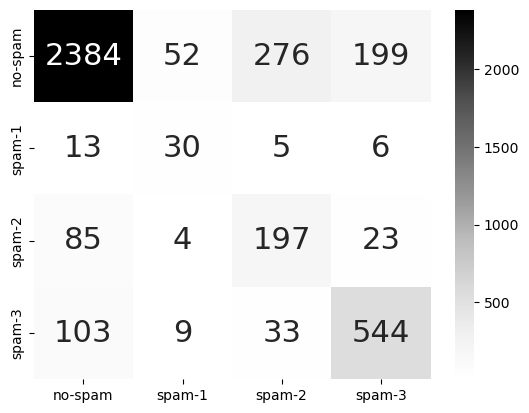

In [40]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - SBERT with BERT4News

In [41]:
from sentence_transformers import SentenceTransformer

model_dir = '../input/vispam-bert4news-description-embedding/'
sentence_model_1 = SentenceTransformer(model_dir + 'training_nli_NlpHUST-vibert4news-base-cased-task-1', device=device)
sentence_model_2 = SentenceTransformer(model_dir + 'training_nli_NlpHUST-vibert4news-base-cased-task-2', device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

vispam_datasets = vispam_datasets.map(encode_description, batched=True)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [42]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    
    return {'input_ids': input_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [43]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)


## Task 1

In [44]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=1, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN_Description_BERT4News", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.6061 - Train F1-score: 0.5643 - Train Loss: 0.6928
Valid Accuracy: 0.6224 - Valid F1-score: 0.5673 - Valid Loss: 0.6667
Validation loss decreased (inf --> 0.666733). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.6343 - Train F1-score: 0.5959 - Train Loss: 0.6541
Valid Accuracy: 0.6595 - Valid F1-score: 0.5989 - Valid Loss: 0.6382
Validation loss decreased (0.666733 --> 0.638246). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.6767 - Train F1-score: 0.6338 - Train Loss: 0.6158
Valid Accuracy: 0.6803 - Valid F1-score: 0.6344 - Valid Loss: 0.5996
Validation loss decreased (0.638246 --> 0.599562). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [45]:
save_visualization_history(history, 'TextCNN_Description_BERT4News', task=1)
plotting_history(history)


In [46]:
import os
import torch

model_name = "TextCNN_Description_BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = TextCNN(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8335
Precision: 0.7860
Recall: 0.7901
F1-score: 0.7880
Confusion matrix:
 [[2569  342]
 [ 318  734]]
              precision    recall  f1-score   support

           0     0.8899    0.8825    0.8862      2911
           1     0.6822    0.6977    0.6898      1052

    accuracy                         0.8335      3963
   macro avg     0.7860    0.7901    0.7880      3963
weighted avg     0.8347    0.8335    0.8341      3963



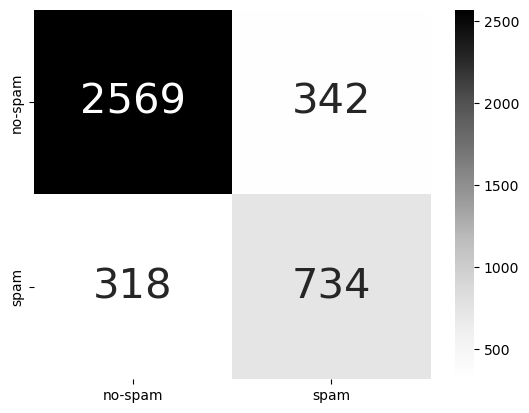

In [47]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [48]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=2, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN_Description_BERT4News", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.4735 - Train F1-score: 0.3313 - Train Loss: 1.1810
Valid Accuracy: 0.5865 - Valid F1-score: 0.4028 - Valid Loss: 1.1105
Validation loss decreased (inf --> 1.110472). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.6207 - Train F1-score: 0.4742 - Train Loss: 0.8268
Valid Accuracy: 0.6885 - Valid F1-score: 0.4792 - Valid Loss: 1.0474
Validation loss decreased (1.110472 --> 1.047351). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.7157 - Train F1-score: 0.5652 - Train Loss: 0.6381
Valid Accuracy: 0.7451 - Valid F1-score: 0.5472 - Valid Loss: 1.0405
Validation loss decreased (1.047351 --> 1.040504). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [49]:
save_visualization_history(history, 'TextCNN_Description_BERT4News', task=2)
plotting_history(history)


In [50]:
import os
import torch

model_name = "TextCNN_Description_BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = TextCNN(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7954
Precision: 0.5954
Recall: 0.6840
F1-score: 0.6267
Confusion matrix:
 [[2453   38  257  163]
 [  16   31    3    4]
 [  96    2  196   15]
 [ 165   14   38  472]]
              precision    recall  f1-score   support

           0     0.8985    0.8427    0.8697      2911
           1     0.3647    0.5741    0.4460        54
           2     0.3968    0.6343    0.4882       309
           3     0.7217    0.6851    0.7029       689

    accuracy                         0.7954      3963
   macro avg     0.5954    0.6840    0.6267      3963
weighted avg     0.8214    0.7954    0.8052      3963



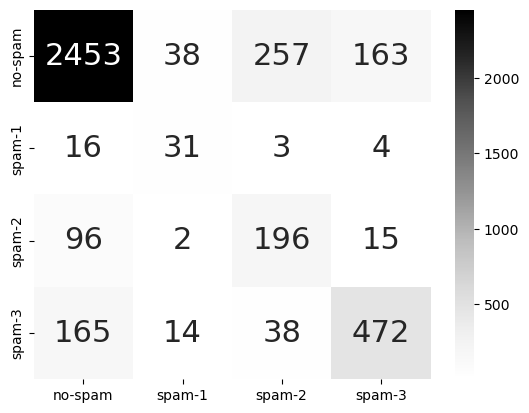

In [51]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - SBERT with BERT4News

## Task 1

In [52]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM_Description_BERT4News", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.6628 - Train F1-score: 0.6231 - Train Loss: 0.6316
Valid Accuracy: 0.7703 - Valid F1-score: 0.7231 - Valid Loss: 0.4995
Validation loss decreased (inf --> 0.499462). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.7975 - Train F1-score: 0.7620 - Train Loss: 0.4476
Valid Accuracy: 0.7948 - Valid F1-score: 0.7567 - Valid Loss: 0.4389
Validation loss decreased (0.499462 --> 0.438921). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.8397 - Train F1-score: 0.8076 - Train Loss: 0.3725
Valid Accuracy: 0.8118 - Valid F1-score: 0.7696 - Valid Loss: 0.4317
Validation loss decreased (0.438921 --> 0.431742). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [53]:
save_visualization_history(history, 'BiLSTM_Description_BERT4News', task=1)
plotting_history(history)


In [54]:
import os
import torch

model_name = "BiLSTM_Description_BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiLSTM(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8433
Precision: 0.8019
Recall: 0.7880
F1-score: 0.7944
Confusion matrix:
 [[2637  274]
 [ 347  705]]
              precision    recall  f1-score   support

           0     0.8837    0.9059    0.8947      2911
           1     0.7201    0.6702    0.6942      1052

    accuracy                         0.8433      3963
   macro avg     0.8019    0.7880    0.7944      3963
weighted avg     0.8403    0.8433    0.8415      3963



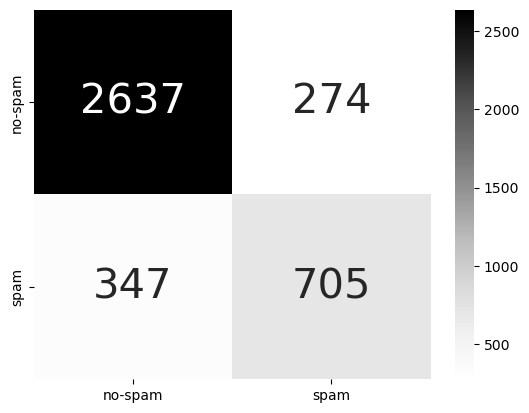

In [55]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [56]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM_Description_BERT4News", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.4080 - Train F1-score: 0.2853 - Train Loss: 1.3206
Valid Accuracy: 0.5047 - Valid F1-score: 0.3353 - Valid Loss: 1.3097
Validation loss decreased (inf --> 1.309679). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.5243 - Train F1-score: 0.3914 - Train Loss: 1.0281
Valid Accuracy: 0.5060 - Valid F1-score: 0.3749 - Valid Loss: 1.0994
Validation loss decreased (1.309679 --> 1.099404). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.5769 - Train F1-score: 0.4537 - Train Loss: 0.8407
Valid Accuracy: 0.5916 - Valid F1-score: 0.4367 - Valid Loss: 1.0788
Validation loss decreased (1.099404 --> 1.078761). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [57]:
save_visualization_history(history, 'BiLSTM_Description_BERT4News', task=2)
plotting_history(history)


In [58]:
import os
import torch

model_name = "BiLSTM_Description_BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiLSTM(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8072
Precision: 0.6361
Recall: 0.6984
F1-score: 0.6577
Confusion matrix:
 [[2469   28  276  138]
 [  17   31    4    2]
 [  94    0  200   15]
 [ 144    4   42  499]]
              precision    recall  f1-score   support

           0     0.9064    0.8482    0.8763      2911
           1     0.4921    0.5741    0.5299        54
           2     0.3831    0.6472    0.4813       309
           3     0.7630    0.7242    0.7431       689

    accuracy                         0.8072      3963
   macro avg     0.6361    0.6984    0.6577      3963
weighted avg     0.8350    0.8072    0.8176      3963



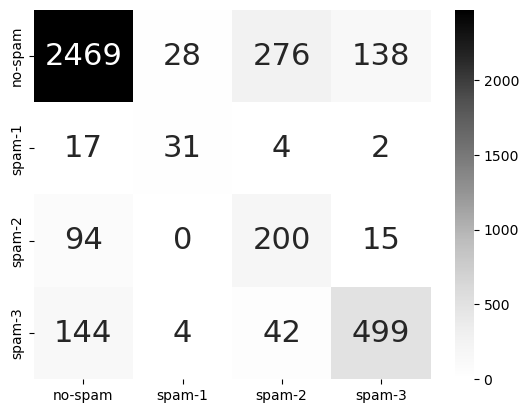

In [59]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - SBERT with BERT4News

## Task 1

In [60]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU_Description_BERT4News", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.6406 - Train F1-score: 0.6034 - Train Loss: 0.6481
Valid Accuracy: 0.7961 - Valid F1-score: 0.7329 - Valid Loss: 0.5200
Validation loss decreased (inf --> 0.520009). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.7942 - Train F1-score: 0.7590 - Train Loss: 0.4499
Valid Accuracy: 0.8188 - Valid F1-score: 0.7724 - Valid Loss: 0.4392
Validation loss decreased (0.520009 --> 0.439231). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.8349 - Train F1-score: 0.8016 - Train Loss: 0.3734
Valid Accuracy: 0.8188 - Valid F1-score: 0.7750 - Valid Loss: 0.4355
Validation loss decreased (0.439231 --> 0.435534). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [61]:
save_visualization_history(history, 'BiGRU_Description_BERT4News', task=1)
plotting_history(history)


In [62]:
import os
import torch

model_name = "BiGRU_Description_BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiGRU(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8370
Precision: 0.7902
Recall: 0.7968
F1-score: 0.7934
Confusion matrix:
 [[2569  342]
 [ 304  748]]
              precision    recall  f1-score   support

           0     0.8942    0.8825    0.8883      2911
           1     0.6862    0.7110    0.6984      1052

    accuracy                         0.8370      3963
   macro avg     0.7902    0.7968    0.7934      3963
weighted avg     0.8390    0.8370    0.8379      3963



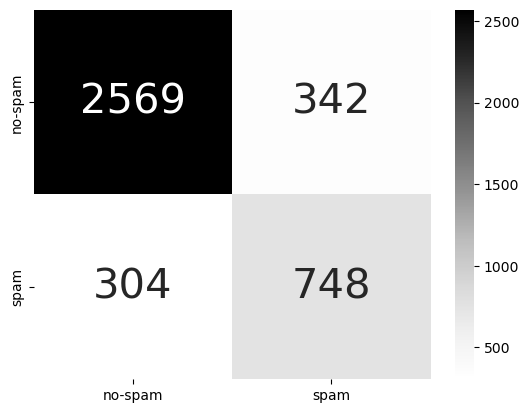

In [63]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [64]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU_Description_BERT4News", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------
Train Accuracy: 0.4250 - Train F1-score: 0.2966 - Train Loss: 1.2901
Valid Accuracy: 0.4512 - Valid F1-score: 0.3120 - Valid Loss: 1.3141
Validation loss decreased (inf --> 1.314148). Saving model ...
Epoch 2/40
----------------------------------------------------------------------
Train Accuracy: 0.5404 - Train F1-score: 0.3939 - Train Loss: 1.0296
Valid Accuracy: 0.6476 - Valid F1-score: 0.4390 - Valid Loss: 1.1958
Validation loss decreased (1.314148 --> 1.195829). Saving model ...
Epoch 3/40
----------------------------------------------------------------------
Train Accuracy: 0.6470 - Train F1-score: 0.4996 - Train Loss: 0.7409
Valid Accuracy: 0.6941 - Valid F1-score: 0.4953 - Valid Loss: 1.0596
Validation loss decreased (1.195829 --> 1.059635). Saving model ...
Epoch 4/40
----------------------------------------------------------------------
Tr

In [65]:
save_visualization_history(history, 'BiGRU_Description_BERT4News', task=2)
plotting_history(history)


In [66]:
import os
import torch

model_name = "BiGRU_Description_BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiGRU(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7701
Precision: 0.5863
Recall: 0.7128
F1-score: 0.6239
Confusion matrix:
 [[2268   41  411  191]
 [  13   31    6    4]
 [  62    3  227   17]
 [ 118    7   38  526]]
              precision    recall  f1-score   support

           0     0.9216    0.7791    0.8444      2911
           1     0.3780    0.5741    0.4559        54
           2     0.3328    0.7346    0.4581       309
           3     0.7127    0.7634    0.7372       689

    accuracy                         0.7701      3963
   macro avg     0.5863    0.7128    0.6239      3963
weighted avg     0.8320    0.7701    0.7903      3963



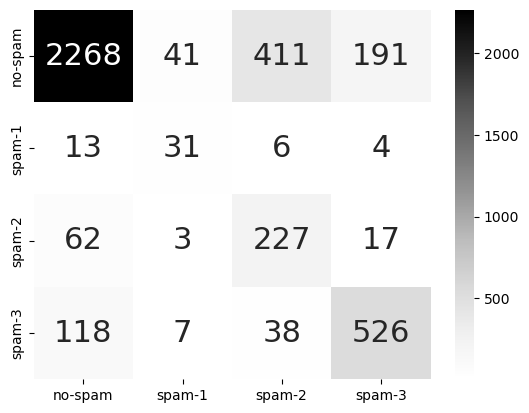

In [67]:
plotting_confusion_matrix(test_cm, task=2)
